# Texas COVID-19 Future Range Weeks' Prediction, trained on historical flu data and temperature

> Once again, just like before in the USA flu model, I am going to index COVID weekly cases by Wednesdays

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
import datetime

### getting historical flu data

In [2]:
flu_dir = "../../../cdc-fludata/us_national/"

In [3]:
flu_dictionary = {}

for year in range(1997, 2019):
    filepath = "usflu_"
    year_string = str(year) + "-" + str(year + 1)
    filepath = flu_dir + filepath + year_string + ".csv"
    temp_df = pd.read_csv(filepath)
    flu_dictionary[year] = temp_df

### combining flu data into one chronological series of total cases

In [4]:
# getting total cases and putting them in a series by week
flu_series_dict = {} 

for year in flu_dictionary:
    temp_df = flu_dictionary[year]
    temp_df = temp_df.set_index("WEEK")
    abridged_df = temp_df.iloc[:, 2:]
    
    try:
        abridged_df = abridged_df.drop(columns="PERCENT POSITIVE")
    except:
        pass
    
    total_cases_series = abridged_df.sum(axis=1)
    flu_series_dict[year] = total_cases_series
    

In [5]:
all_cases_series = pd.Series(dtype="int64")

for year in flu_series_dict:
    temp_series = flu_series_dict[year]
    all_cases_series = all_cases_series.append(temp_series, ignore_index=True)

In [6]:
all_cases_series

0         0
1        11
2        17
3         7
4        10
       ... 
1143     87
1144    110
1145    143
1146    147
1147    152
Length: 1148, dtype: int64

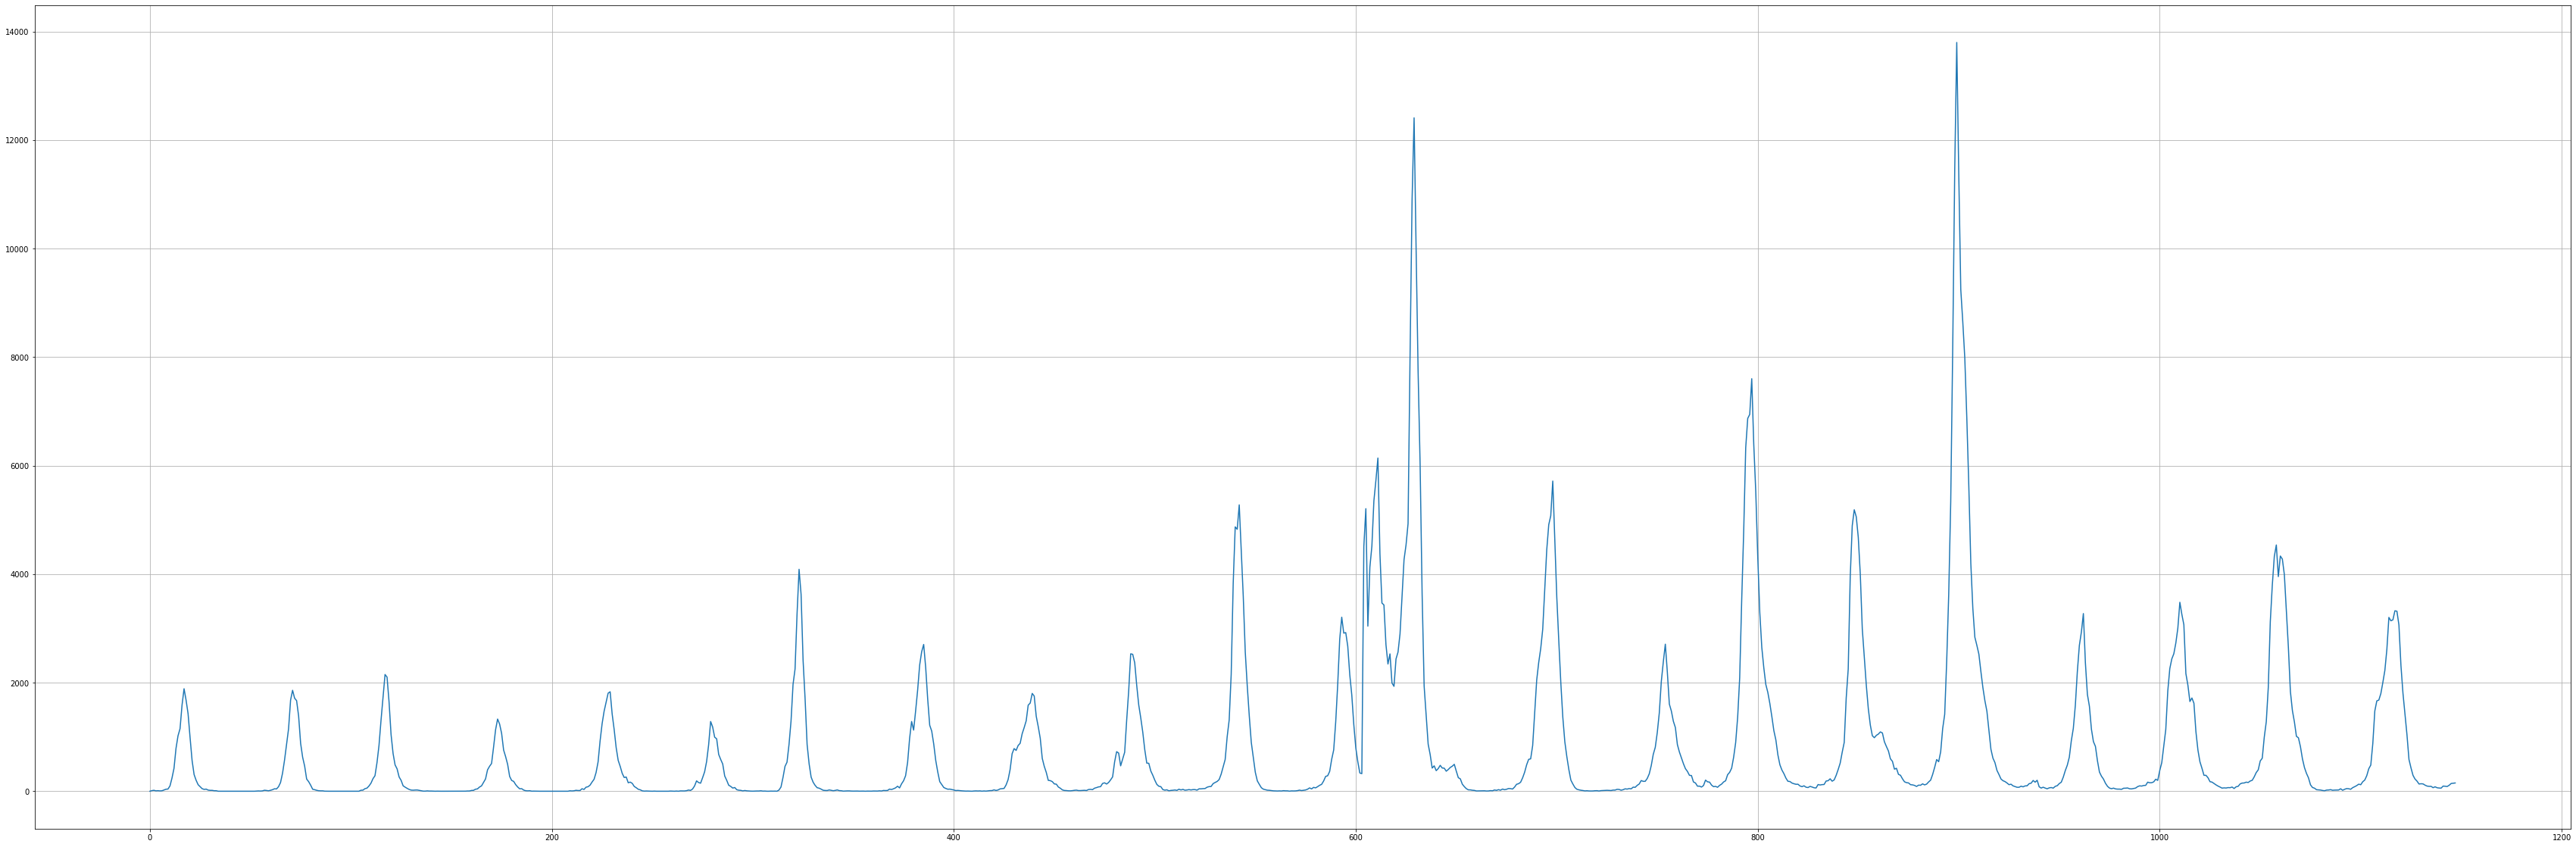

In [7]:
all_cases_series.plot(grid=True, figsize=(60,20))

### Now, making a normalized series between 0, 1

In [8]:
norm_flu_series_dict = {}

for year in flu_series_dict:
    temp_series = flu_series_dict[year]
    temp_list = preprocessing.minmax_scale(temp_series)
    temp_series = pd.Series(temp_list)
    norm_flu_series_dict[year] = temp_series

In [9]:
all_cases_norm_series = pd.Series(dtype="int64")

for year in norm_flu_series_dict:
    temp_series = norm_flu_series_dict[year]
    all_cases_norm_series = all_cases_norm_series.append(temp_series, ignore_index=True)

0       0.000000
1       0.005823
2       0.008999
3       0.003706
4       0.005294
          ...   
1143    0.009180
1144    0.016218
1145    0.026316
1146    0.027540
1147    0.029070
Length: 1148, dtype: float64

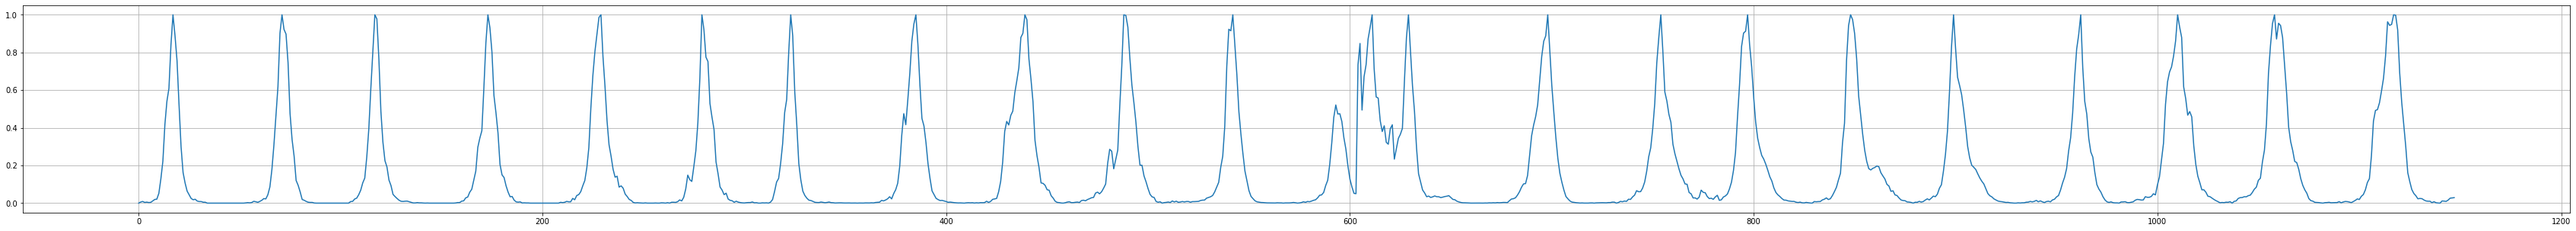

In [10]:
all_cases_norm_series.plot(grid=True, figsize=(60,5))
all_cases_norm_series

## Getting COVID-19 Case Data

In [11]:
datapath = "../../../COVID-19/csse_covid_19_data/csse_covid_19_time_series/"

# Choose from "US Cases", "US Deaths", "World Cases", "World Deaths", "World Recoveries"
key = "US Cases" 

if key == "US Cases":
    datapath = datapath + "time_series_covid19_confirmed_US.csv"
elif key == "US Deaths":
    datapath = datapath + "time_series_covid19_deaths_US.csv"
elif key == "World Cases":
    datapath = datapath + "time_series_covid19_confirmed_global.csv"
elif key == "World Deaths":
    datapath = datapath + "time_series_covid19_deaths_global.csv"
elif key == "World Recoveries":
    datapath = datapath + "time_series_covid19_recovered_global.csv"

In [12]:
covid_df = pd.read_csv(datapath)

In [13]:
covid_df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,222,225,226,231,247,247,247,253,257,267
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,30,30,30,30,30,30,30,30,30,30
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,...,6564,6685,6820,6877,6922,7066,7189,7250,7465,7537
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,...,76,76,76,80,81,81,81,81,81,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256,84070016,US,USA,840,NaN,Central Utah,Utah,US,39.372319,-111.575868,...,110,114,117,117,127,134,143,159,169,173
3257,84070017,US,USA,840,NaN,Southeast Utah,Utah,US,38.996171,-110.701396,...,31,31,32,32,33,34,35,35,36,37
3258,84070018,US,USA,840,NaN,Southwest Utah,Utah,US,37.854472,-111.441876,...,1104,1151,1200,1258,1302,1361,1428,1467,1519,1553
3259,84070019,US,USA,840,NaN,TriCounty,Utah,US,40.124915,-109.517442,...,39,39,40,42,45,46,48,48,50,50


In [14]:
region_string = "Texas"
region_data = covid_df.loc[covid_df["Province_State"] == region_string]

In [15]:
region_cases = region_data.iloc[:,11:]

In [16]:
region_cases_total = region_cases.sum(axis=0)

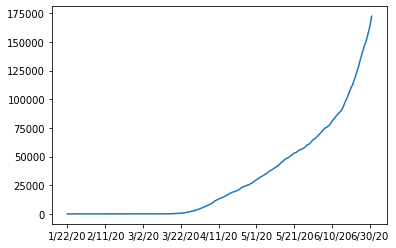

In [17]:
region_cases_total.plot()

### convert daily data to weekly data

In [18]:
region_weekly_cases = region_cases_total.iloc[::7]

In [19]:
region_weekly_cases

1/22/20         0
1/29/20         0
2/5/20          0
2/12/20         0
2/19/20         0
2/26/20         0
3/4/20          0
3/11/20        21
3/18/20       196
3/25/20      1229
4/1/20       4355
4/8/20       9777
4/15/20     15907
4/22/20     21321
4/29/20     27257
5/6/20      34928
5/13/20     43020
5/20/20     51673
5/27/20     58542
6/3/20      68877
6/10/20     80777
6/17/20     97699
6/24/20    128132
7/1/20     172368
dtype: int64

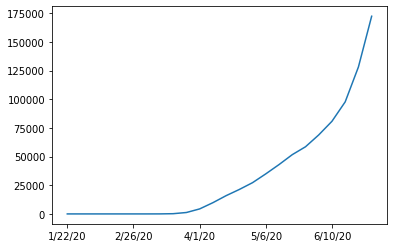

In [20]:
region_weekly_cases.plot()

### Converting cumulative series to non-cumulative series

In [21]:
region_wnew_cases = region_weekly_cases.diff()
region_wnew_cases[0] = 1.0
region_wnew_cases

1/22/20        1.0
1/29/20        0.0
2/5/20         0.0
2/12/20        0.0
2/19/20        0.0
2/26/20        0.0
3/4/20         0.0
3/11/20       21.0
3/18/20      175.0
3/25/20     1033.0
4/1/20      3126.0
4/8/20      5422.0
4/15/20     6130.0
4/22/20     5414.0
4/29/20     5936.0
5/6/20      7671.0
5/13/20     8092.0
5/20/20     8653.0
5/27/20     6869.0
6/3/20     10335.0
6/10/20    11900.0
6/17/20    16922.0
6/24/20    30433.0
7/1/20     44236.0
dtype: float64

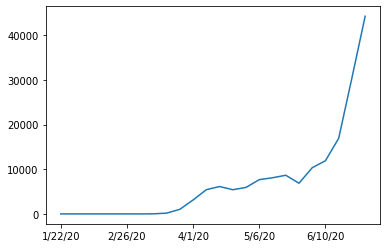

In [22]:
region_wnew_cases.plot()

### normalizing weekly case data
> This is going to be different for texas. This is because, the peak number of weekly new infections probably has not been reached yet. We need to divide everything by a guess for the peak number of predictions instead of min-max scaling.

1/22/20    0.000013
1/29/20    0.000000
2/5/20     0.000000
2/12/20    0.000000
2/19/20    0.000000
2/26/20    0.000000
3/4/20     0.000000
3/11/20    0.000280
3/18/20    0.002333
3/25/20    0.013773
4/1/20     0.041680
4/8/20     0.072293
4/15/20    0.081733
4/22/20    0.072187
4/29/20    0.079147
5/6/20     0.102280
5/13/20    0.107893
5/20/20    0.115373
5/27/20    0.091587
6/3/20     0.137800
6/10/20    0.158667
6/17/20    0.225627
6/24/20    0.405773
7/1/20     0.589813
dtype: float64

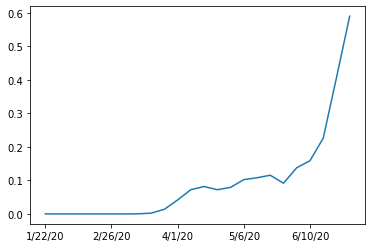

In [23]:
# I'm guessing that the peak number of weekly cases will be about 60,000. Could definitely be wrong.
peak_guess = 75000

region_wnew_cases_norm = region_wnew_cases / peak_guess
region_wnew_cases_norm.plot()
region_wnew_cases_norm

## getting temperature data
> At the moment, this will be dummy data

In [24]:
flu_temp_data = np.full(len(all_cases_norm_series), 0.5)

In [25]:
training_data_df = pd.DataFrame({
    "Temperature" : flu_temp_data,
    "Flu Cases" : all_cases_norm_series
})
training_data_df

,Temperature,Flu Cases
0,0.5,0.000000
1,0.5,0.005823
2,0.5,0.008999
3,0.5,0.003706
4,0.5,0.005294
...,...,...
1143,0.5,0.009180
1144,0.5,0.016218
1145,0.5,0.026316
1146,0.5,0.027540


In [26]:
covid_temp_data = np.full(len(region_wnew_cases_norm), 0.5)

In [27]:
testing_data_df = pd.DataFrame({
    "Temperature" : covid_temp_data,
    "COVID Cases" : region_wnew_cases_norm
})
testing_data_df

,Temperature,COVID Cases
1/22/20,0.5,0.000013
1/29/20,0.5,0.000000
2/5/20,0.5,0.000000
2/12/20,0.5,0.000000
2/19/20,0.5,0.000000
2/26/20,0.5,0.000000
3/4/20,0.5,0.000000
3/11/20,0.5,0.000280
3/18/20,0.5,0.002333
3/25/20,0.5,0.013773


In [28]:
testing_data_df.shape

(24, 2)

In [29]:
training_data_np = training_data_df.values
testing_data_np = testing_data_df.values

## Building Neural Net Model

### preparing model data

In [30]:
# this code is directly from https://www.tensorflow.org/tutorials/structured_data/time_series
# much of below data formatting code is derived straight from same link

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [31]:
past_history = testing_data_df.shape[0]
future_target = 7
STEP = 1

x_train_single, y_train_single = multivariate_data(training_data_np, training_data_np[:, 1], 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=False)

In [32]:
print(x_train_single.shape, y_train_single.shape)

(1117, 24, 2) (1117, 7)


In [33]:
BATCH_SIZE = 300
BUFFER_SIZE = 1000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

### designing actual model

In [34]:
# creating the neural network model

lstm_prediction_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_single.shape[-2:]),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dense(future_target)
])

lstm_prediction_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss="mae")

In [35]:
single_step_history = lstm_prediction_model.fit(train_data_single, epochs=10,
                                            steps_per_epoch=250)

Train for 250 steps
Epoch 1/10
250/250 [==============================] - 32s 127ms/step - loss: 0.1307
Epoch 2/10
250/250 [==============================] - 28s 112ms/step - loss: 0.0864
Epoch 3/10
250/250 [==============================] - 28s 113ms/step - loss: 0.0697
Epoch 4/10
250/250 [==============================] - 28s 113ms/step - loss: 0.0620
Epoch 5/10
250/250 [==============================] - 28s 112ms/step - loss: 0.0574
Epoch 6/10
250/250 [==============================] - 28s 112ms/step - loss: 0.0543
Epoch 7/10
250/250 [==============================] - 28s 113ms/step - loss: 0.0520
Epoch 8/10
250/250 [==============================] - 28s 112ms/step - loss: 0.0500
Epoch 9/10
250/250 [==============================] - 28s 113ms/step - loss: 0.0483
Epoch 10/10
250/250 [==============================] - 28s 114ms/step - loss: 0.0466


In [36]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  return plt

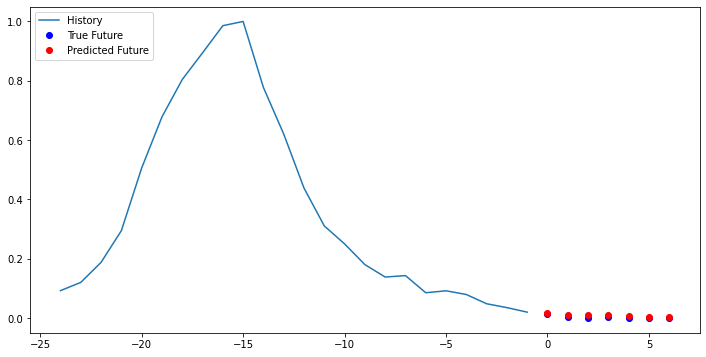

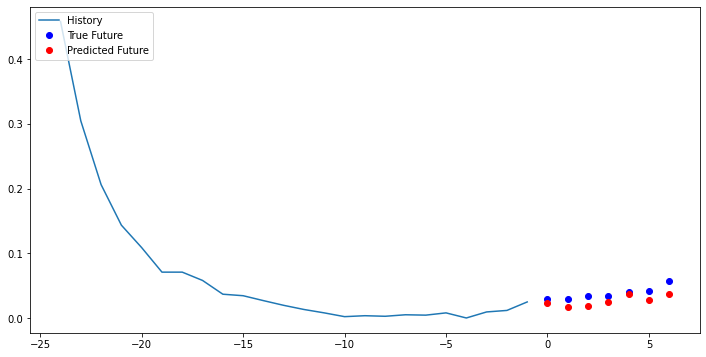

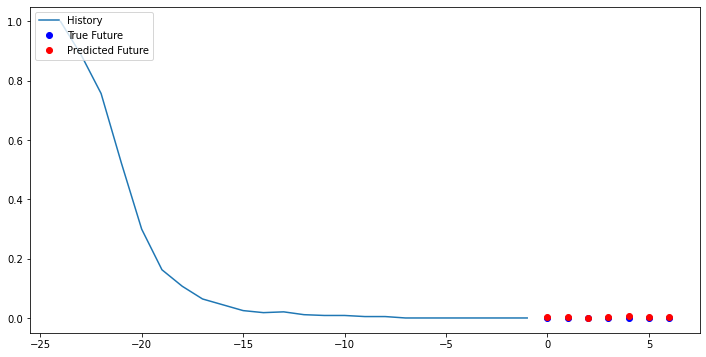

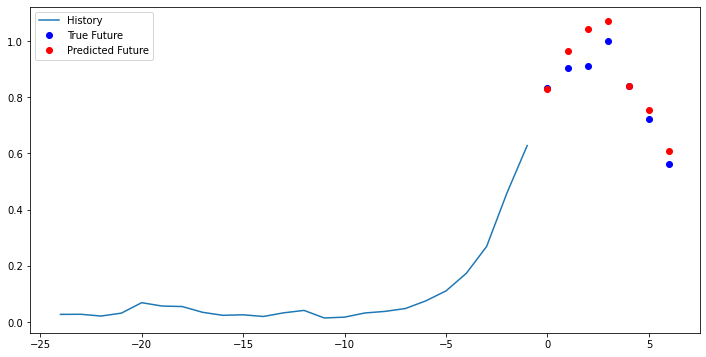

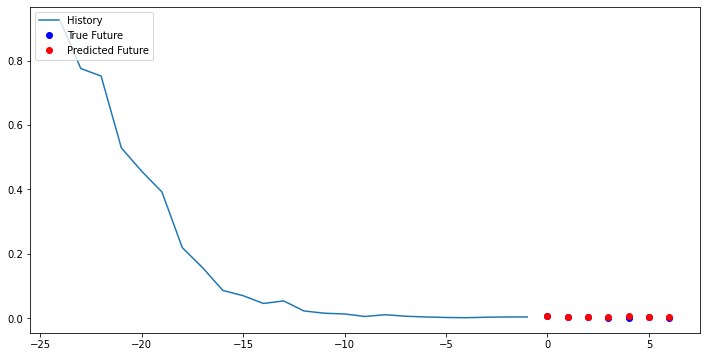

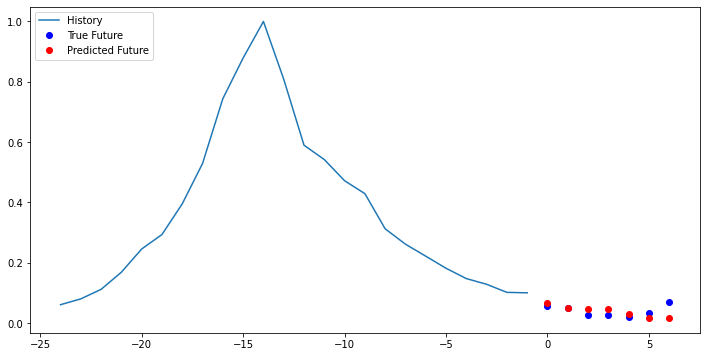

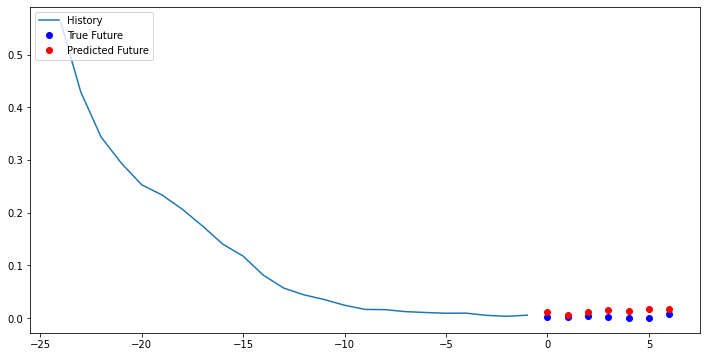

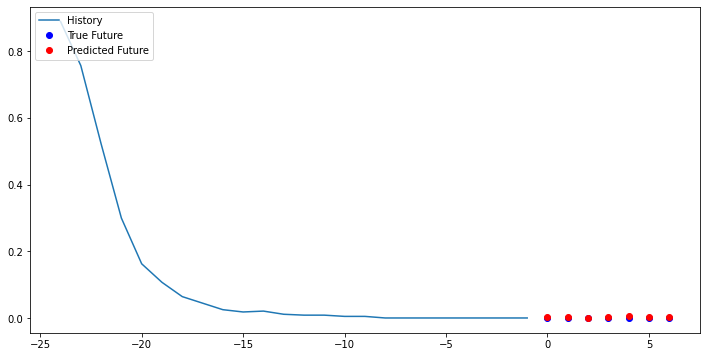

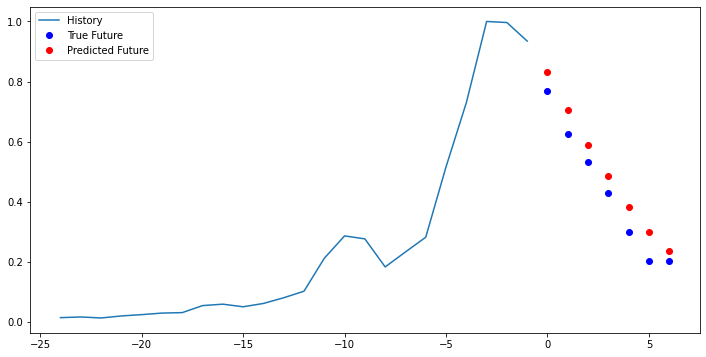

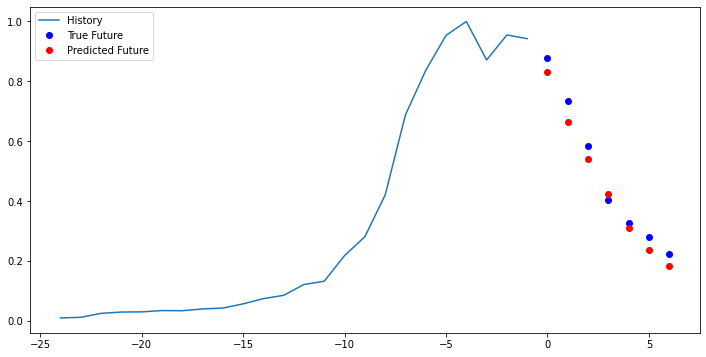

In [37]:
for x, y in train_data_single.take(10):
  #print(lstm_prediction_model.predict(x))
  multi_step_plot(x[0], y[0], lstm_prediction_model.predict(x)[0])

## Actual Range Predictions of Future COVID-19 Cases

In [38]:
dummy_data = np.full((future_target+1,2), [0.5, 1])
new_testing_data_np = np.append(testing_data_np, dummy_data, axis=0)
new_testing_data_np.shape

(32, 2)

In [39]:
x_test_single, y_test_single = multivariate_data(new_testing_data_np, new_testing_data_np[:, 1],
                                               0, None, past_history,
                                               future_target, STEP,
                                               single_step=False)

test_data_single = tf.data.Dataset.from_tensor_slices((x_test_single, y_test_single))
test_data_single = test_data_single.batch(1).repeat()

In [40]:
def multi_step_prediction(history, prediction):
  plt.figure()
  num_in = create_time_steps(len(history))
  num_out = len(prediction)

  plt.plot(num_in, np.array(history[:, 1]), '.-', label='History')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'go',
             label='Predicted Future')
  plt.legend(loc='upper left')
  return plt

In [41]:
today_date = datetime.date.today()
today_datestring = today_date.strftime("%m/%d/%Y")

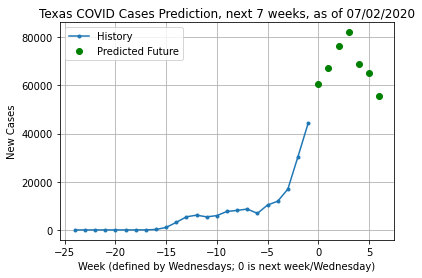

In [42]:
for x, y in test_data_single.take(1):
    predicted_cases = lstm_prediction_model.predict(x)[0]
    plot = multi_step_prediction(x[0] * peak_guess, predicted_cases * peak_guess)
    plot.title(region_string + " COVID Cases Prediction, next 7 weeks, as of " + today_datestring)
    plot.xlabel('Week (defined by Wednesdays; 0 is next week/Wednesday)')
    plot.ylabel('New Cases')
    plot.grid()
    plot.show()